In [40]:
import sys 
sys.path.append('../')

In [41]:
# !wget https://raw.githubusercontent.com/ML4SCI/ML4SCIHackathon/main/ParticleImagesChallenge/images/CollisionImage.png

In [153]:
import numpy as np
np.random.seed(1337)  # for reproducibility

import tensorflow.keras as keras
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})
import pickle

import utils as pic
    
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
lr_init     = 1.e-5    # Initial learning rate  
batch_size  = 100       # Training batch size
train_size  = 4000     # Training size
valid_size  = 1000     # Validation size
test_size   = 1000     # Test size
epochs      = 20       # Number of epochs
doGPU       = False    # Use GPU
tmin        = -0.1    # Minimum time cutoff
tmax        = 0.1     # Maximum time cutoff
tstep       = 0.0099   # Time steps

In [101]:
# Set range of training set
train_start, train_stop = 0, train_size
assert train_stop > train_start
assert (len(pic.decays)*train_size) % batch_size == 0
X_train, y_train = pic.load_data(train_start,train_stop)

# Set range of validation set
valid_start, valid_stop = 160000, 160000+valid_size
assert valid_stop  >  valid_start
assert valid_start >= train_stop
X_valid, y_valid = pic.load_data(valid_start,valid_stop)

# Set range of test set
test_start, test_stop = 204800, 204800+test_size
assert test_stop  >  test_start
assert test_start >= valid_stop
X_test, y_test = pic.load_data(test_start,test_stop)

samples_requested = len(pic.decays) * (train_size + valid_size + test_size)
samples_available = len(y_train) + len(y_valid) + len(y_test)
assert samples_requested == samples_available

In [45]:
X_train = pic.remove_empty_pixels(X_train)

In [46]:
energy = X_train[:,:,:,0]
timing = X_train[:,:,:,1]

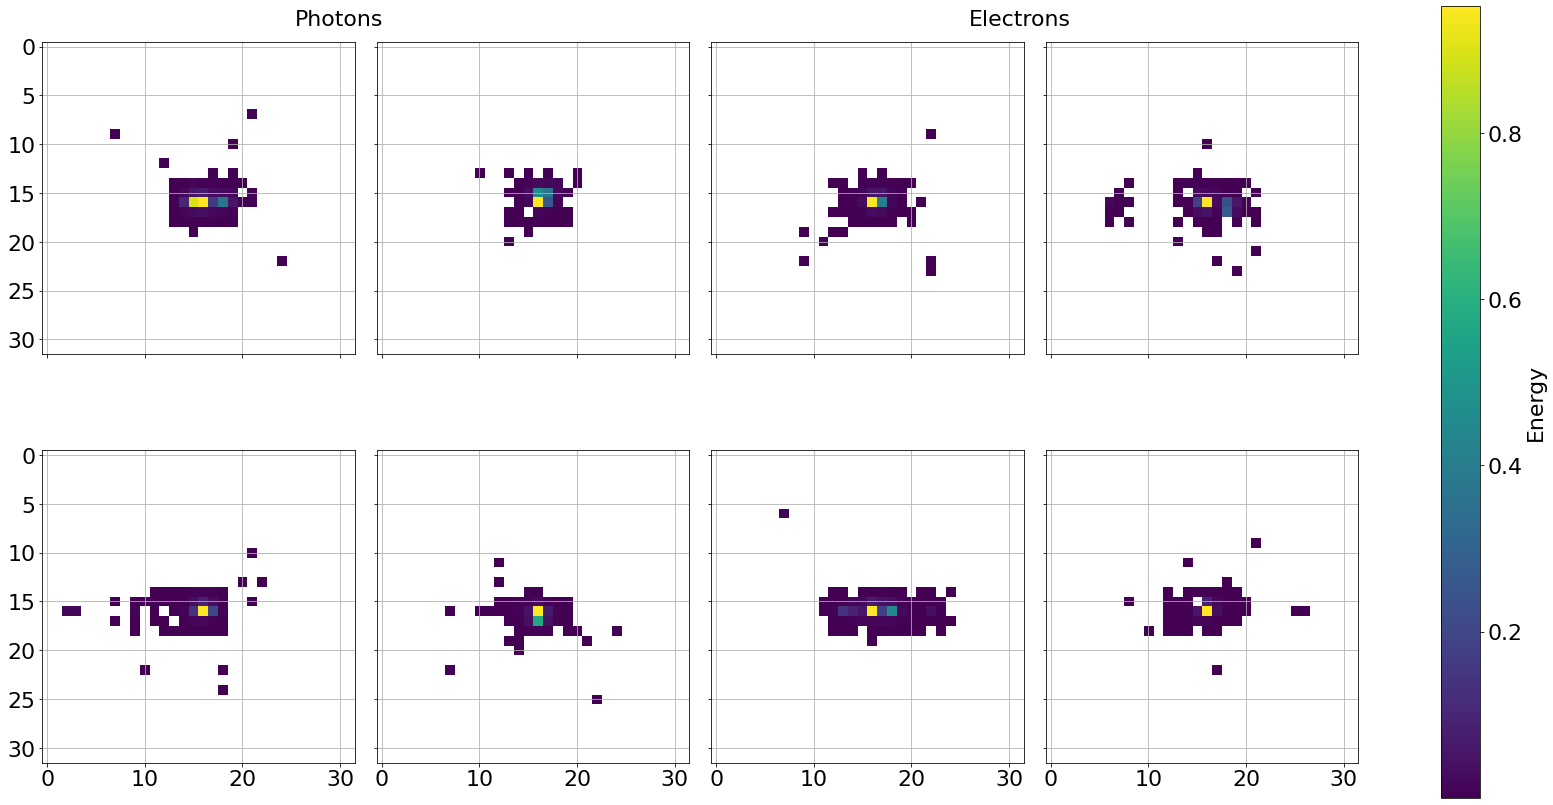

In [155]:
fig,axs = plt.subplots(2,4,figsize=(24,12),sharex=True,sharey=True)

ph_axs = axs[:,:2]
el_axs = axs[:,2:]
for i in range(4):
    ph_axs.flat[i].imshow(energy[i])
    ph_axs.flat[i].grid()
    im = el_axs.flat[i].imshow(energy[-1-i])
    el_axs.flat[i].grid()

fig.text(0.18,0.95,'Photons')
fig.text(0.57,0.95,'Electrons')
fig.tight_layout()
fig.colorbar(im,ax=np.array(axs.ravel().tolist()),label='Energy') 

fig.savefig('energy-images.jpg')

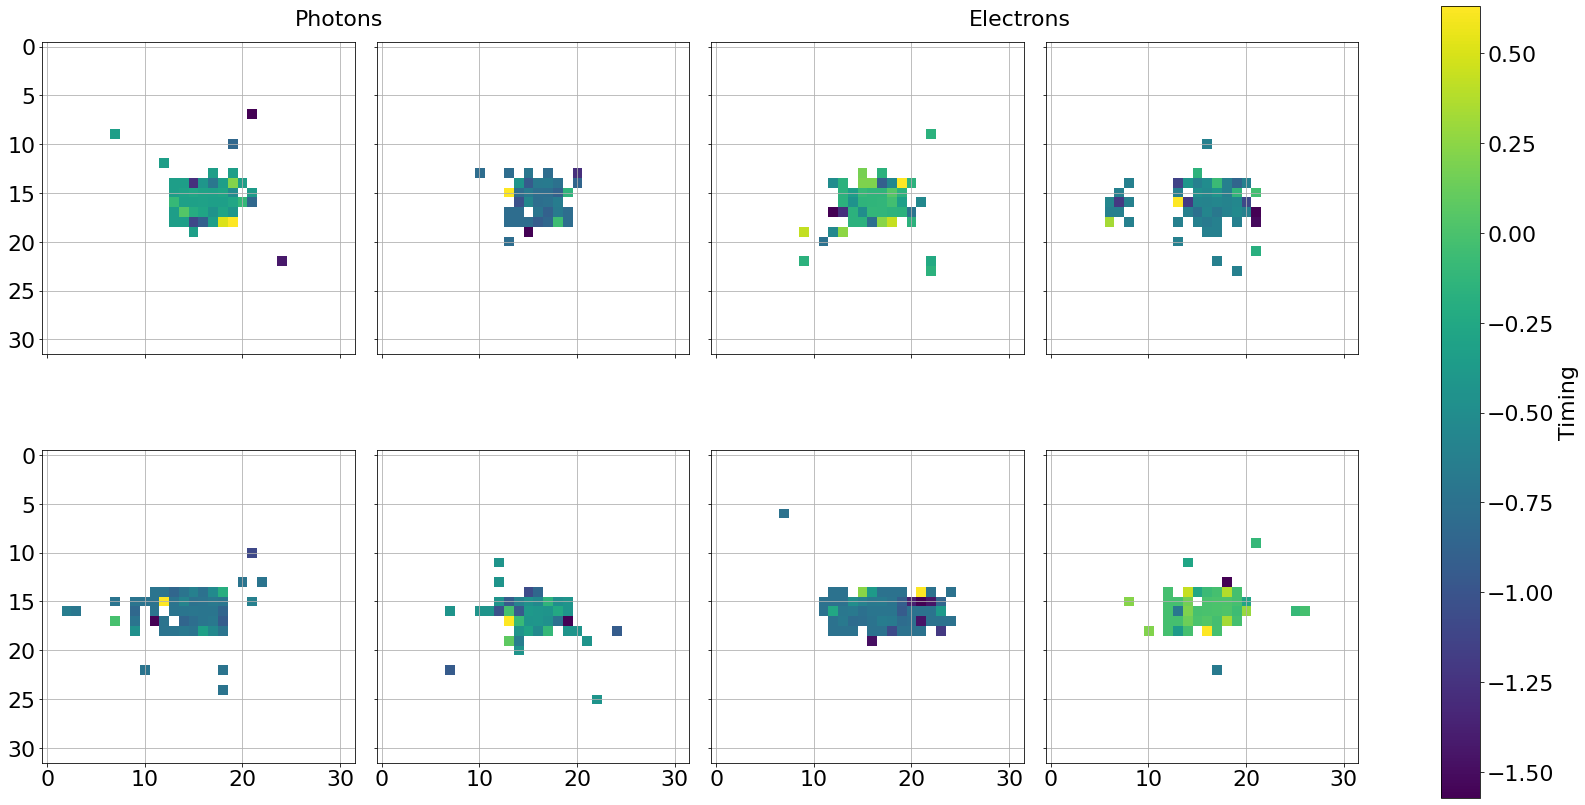

In [156]:
fig,axs = plt.subplots(2,4,figsize=(24,12),sharex=True,sharey=True)

ph_axs = axs[:,:2]
el_axs = axs[:,2:]
for i in range(4):
    ph_axs.flat[i].imshow(timing[i])
    ph_axs.flat[i].grid()
    im = el_axs.flat[i].imshow(timing[-1-i])
    el_axs.flat[i].grid()

fig.text(0.18,0.95,'Photons')
fig.text(0.57,0.95,'Electrons')
fig.tight_layout()
fig.colorbar(im,ax=np.array(axs.ravel().tolist()),label='Timing') 

fig.savefig('timing-images.jpg')

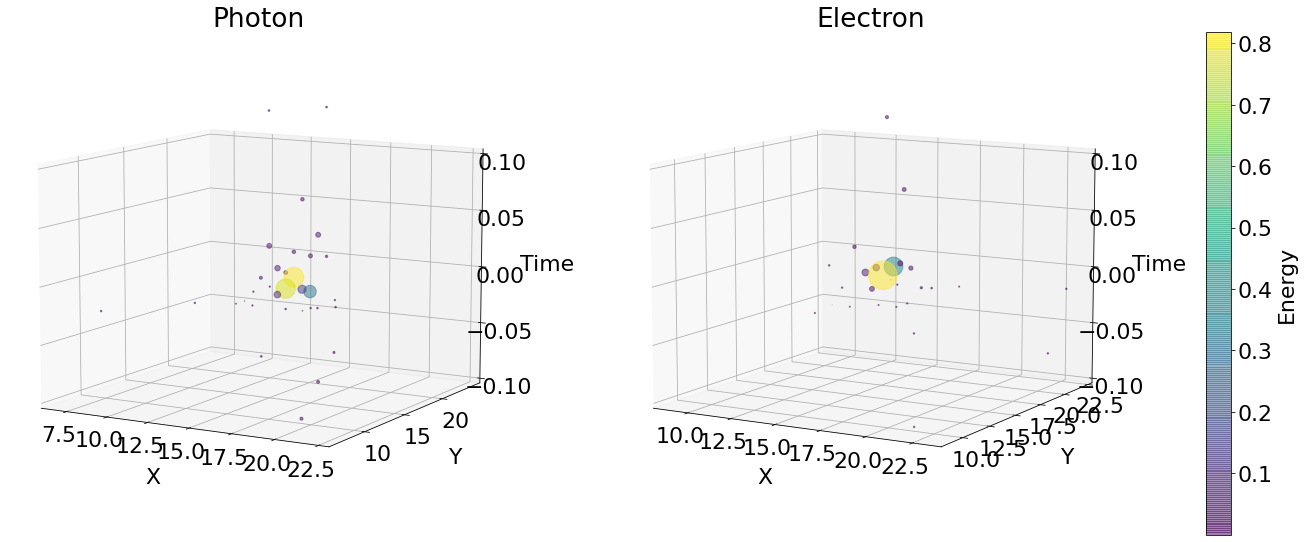

In [163]:
fig = plt.figure(figsize=(24,8))

spacetime,_ = pic.spacetime_scatter(X_train)

ax1 = fig.add_subplot(1,2,1,projection='3d')
sc = ax1.scatter(spacetime[0,:,2],spacetime[0,:,3],spacetime[0,:,1],s=1000*spacetime[0,:,0],c=spacetime[0,:,0],alpha=0.5)
ax1.set_zlim(-0.1,0.1)
ax1.view_init(elev=10)
ax1.set_title('Photon')
ax1.set_xlabel('X',labelpad=20)
ax1.set_ylabel('Y',labelpad=20)
ax1.set_zlabel('Time',labelpad=20)

ax2 = fig.add_subplot(1,2,2,projection='3d')
sc = ax2.scatter(spacetime[-1,:,2],spacetime[-1,:,3],spacetime[-1,:,1],s=1000*spacetime[-1,:,0],c=spacetime[-1,:,0],alpha=0.5)
ax2.set_zlim(-0.1,0.1)
ax2.view_init(elev=10)
ax2.set_title('Electron')
ax2.set_xlabel('X',labelpad=20)
ax2.set_ylabel('Y',labelpad=20)
ax2.set_zlabel('Time',labelpad=20)

fig.tight_layout()

fig.colorbar(sc,ax=[ax1,ax2],label='Energy')

fig.savefig('spacetime-scatter.jpg')


In [59]:
# !wget https://ars.els-cdn.com/content/image/1-s2.0-S0010448518301349-gr3_lrg.jpg

--2021-11-29 17:37:30--  https://ars.els-cdn.com/content/image/1-s2.0-S0010448518301349-gr3_lrg.jpg
Resolving ars.els-cdn.com (ars.els-cdn.com)... 104.17.143.36, 104.17.142.36, 2606:4700::6811:8e24, ...
Connecting to ars.els-cdn.com (ars.els-cdn.com)|104.17.143.36|:443... connected.
HTTP request sent, awaiting response... 200 
Length: 402237 (393K) [image/jpeg]
Saving to: ‘1-s2.0-S0010448518301349-gr3_lrg.jpg’

100%[======================================>] 402,237     --.-K/s   in 0.08s   

2021-11-29 17:37:30 (4.70 MB/s) - ‘1-s2.0-S0010448518301349-gr3_lrg.jpg’ saved [402237/402237]



In [165]:
e_gif,t_gif,maxframes,time_bins = pic.timeordered_BC(X_train,cumulative=True,min_t=-0.1,max_t=0.1)

In [120]:
sorted_best = np.argsort(-np.sum(np.any(e_gif.reshape(-1,maxframes,32*32)>0,axis=-1),axis=-1))

In [125]:
np.where(sorted_best>4000)
sorted_best[3]

4486

MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.


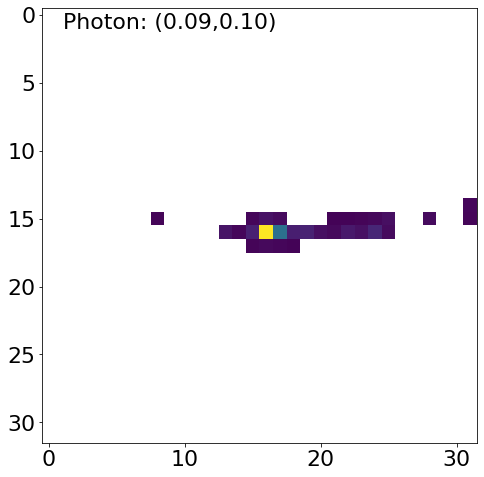

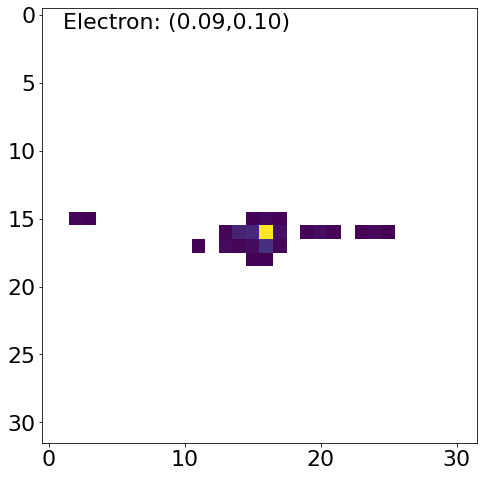

In [166]:
ani = pic.inline_animation(e_gif,y_train,time_bins,interval=200,event=2558)
ani.save('photon.gif')

ani = pic.inline_animation(e_gif,y_train,time_bins,interval=200,event=4486)
ani.save('electron.gif')

In [135]:
modeldir = '../models/cnn3d-v2-1.00e-01-9.90e-03/'
model = keras.models.load_model(modeldir)
with open(f'{modeldir}/history.pkl','rb') as f_history: history = pickle.load(f_history)

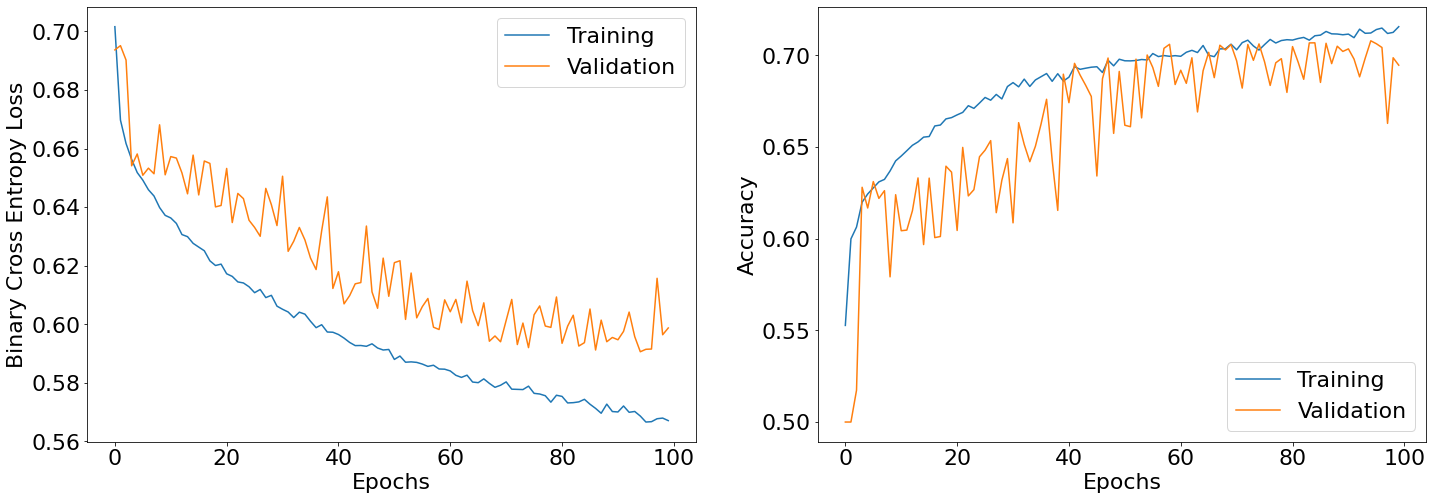

In [167]:
fig,axs = plt.subplots(ncols=2,figsize=(24,8))

axs[0].plot(history['loss'],label='Training')
axs[0].plot(history['val_loss'],label='Validation')
axs[0].set(xlabel='Epochs',ylabel='Binary Cross Entropy Loss')
axs[0].legend()

axs[1].plot(history['accuracy'],label='Training')
axs[1].plot(history['val_accuracy'],label='Validation')
axs[1].set(xlabel='Epochs',ylabel='Accuracy')
axs[1].legend()

# fig.tight_layout()
fig.savefig('model-history.jpg')

In [168]:
e_gif,t_gif,maxframes,time_bins = pic.timeordered_BC(X_test,cumulative=True,min_t=-0.1,max_t=0.1)

y_pred = model.predict(e_gif)[:,1]

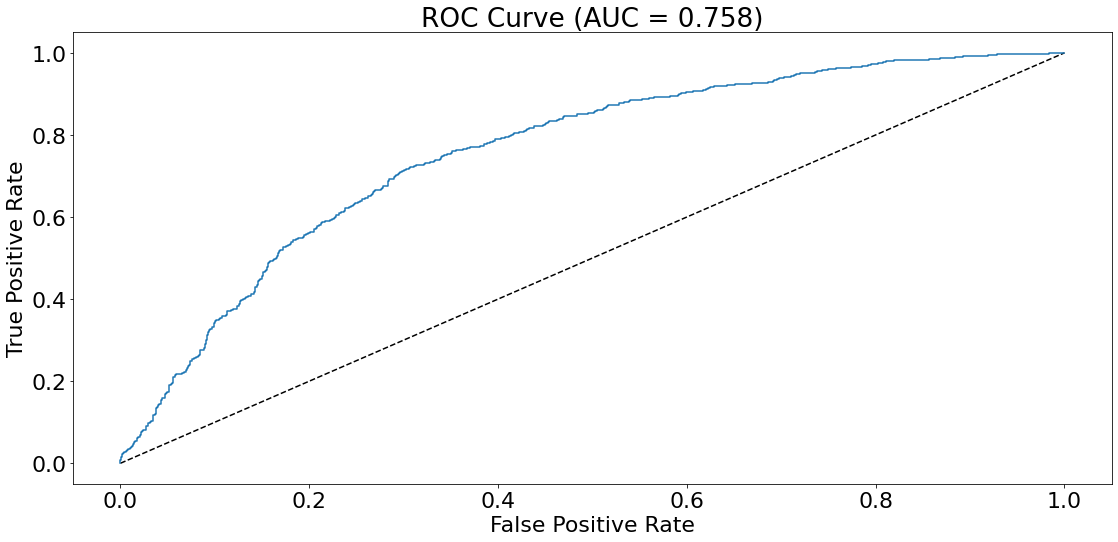

In [169]:
fig,ax = plt.subplots(figsize=(16,8))
pic.plot_roc(y_test,y_pred,figax=(fig,ax))
fig.tight_layout()
fig.savefig('model-roc.jpg')

In [152]:
# !wget https://upload.wikimedia.org/wikipedia/commons/thumb/1/13/Roc_curve.svg/800px-Roc_curve.svg.png

--2021-11-29 19:29:48--  https://upload.wikimedia.org/wikipedia/commons/thumb/1/13/Roc_curve.svg/800px-Roc_curve.svg.png
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84594 (83K) [image/png]
Saving to: ‘800px-Roc_curve.svg.png’

100%[======================================>] 84,594      --.-K/s   in 0.04s   

2021-11-29 19:29:48 (1.99 MB/s) - ‘800px-Roc_curve.svg.png’ saved [84594/84594]

